# Loading and rendering GLTF files
You can [import meshes from GLTF](https://kaolin.readthedocs.io/en/latest/modules/kaolin.io.gltf.html) and render them and plug the renderer into Kaolin's [interactive renderer](https://kaolin.readthedocs.io/en/latest/modules/kaolin.visualize.html).

In [1]:
pip install matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import math
import copy
import os

import torch
from matplotlib import pyplot as plt
from tutorial_common import COMMON_DATA_DIR

import kaolin as kal

import nvdiffrast
glctx = nvdiffrast.torch.RasterizeCudaContext(device='cuda')

# Rendering function
To use the interactive visualizer, we must implement a rendering function that take a camera as input.

We first start with a base rendering function that will render a mesh given a camera and a light source represented as a [Spherical Gaussian](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.lighting.html).

In [3]:
def generate_pinhole_rays_dir(camera, height, width, device='cuda'):
    """Generate centered grid.
    
    This is a utility function for specular reflectance with spherical gaussian.
    """
    pixel_y, pixel_x = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    pixel_x = pixel_x + 0.5  # scale and add bias to pixel center
    pixel_y = pixel_y + 0.5  # scale and add bias to pixel center

    # Account for principal point (offsets from the center)
    pixel_x = pixel_x - camera.x0
    pixel_y = pixel_y + camera.y0

    # pixel values are now in range [-1, 1], both tensors are of shape res_y x res_x
    # Convert to NDC
    pixel_x = 2 * (pixel_x / width) - 1.0
    pixel_y = 2 * (pixel_y / height) - 1.0

    ray_dir = torch.stack((pixel_x * camera.tan_half_fov(kal.render.camera.intrinsics.CameraFOV.HORIZONTAL),
                           -pixel_y * camera.tan_half_fov(kal.render.camera.intrinsics.CameraFOV.VERTICAL),
                           -torch.ones_like(pixel_x)), dim=-1)

    ray_dir = ray_dir.reshape(-1, 3)    # Flatten grid rays to 1D array
    ray_orig = torch.zeros_like(ray_dir)

    # Transform from camera to world coordinates
    ray_orig, ray_dir = camera.extrinsics.inv_transform_rays(ray_orig, ray_dir)
    ray_dir /= torch.linalg.norm(ray_dir, dim=-1, keepdim=True)

    return ray_dir[0].reshape(1, height, width, 3)

def base_render(camera, height, width, mesh, azimuth, elevation, amplitude, sharpness):
    """Base rendering function"""
    vertices_camera = camera.extrinsics.transform(mesh.vertices)
    vertices_clip = camera.intrinsics.project(vertices_camera)
    face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(
        vertices_camera, mesh.faces)
    faces_int = mesh.faces.int()
    rast = nvdiffrast.torch.rasterize(
        glctx, vertices_clip, faces_int,
        (height, width), grad_db=False)
    rast0 = torch.flip(rast[0], dims=(1,))
    hard_mask = rast0[:, :, :, -1:] != 0
    face_idx = (rast0[..., -1].long() - 1).contiguous()
    coords = nvdiffrast.torch.interpolate(
        vertices_camera, rast0, faces_int
    )[0]
    if mesh.has_or_can_compute_attribute('vertex_normals'):
        im_base_normals = nvdiffrast.torch.interpolate(
            mesh.vertex_normals, rast0, faces_int
        )[0]
    elif mesh.has_or_can_compute_attribute('normals') and mesh.has_attribute('face_normals_idx'):
        im_base_normals = nvdiffrast.torch.interpolate(
            mesh.normals, rast0, mesh.face_normals_idx.int()
        )[0]
    else:
        raise KeyError("mesh has no normal information")
    vertices_ndc = kal.render.camera.intrinsics.down_from_homogeneous(vertices_clip)
    face_vertices_ndc = kal.ops.mesh.index_vertices_by_faces(
        vertices_ndc, mesh.faces
    )
    edges_dist0 = face_vertices_ndc[:, :, 1, :2] - face_vertices_ndc[:, :, 0, :2]
    edges_dist1 = face_vertices_ndc[:, :, 2, :2] - face_vertices_ndc[:, :, 0, :2]
    face_normal_sign = edges_dist0[..., 0] * edges_dist1[..., 1] - edges_dist1[..., 0] * edges_dist0[..., 1]

    im_normal_sign = torch.sign(face_normal_sign[0, face_idx])
    im_normal_sign[face_idx == -1] = 0.
    im_base_normals *= im_normal_sign.unsqueeze(-1)

    if mesh.uvs is not None:
        uv_map = nvdiffrast.torch.interpolate(
            mesh.uvs, rast0, mesh.face_uvs_idx.int()
        )[0] % 1.
        im_tangents = nvdiffrast.torch.interpolate(
            mesh.vertex_tangents, rast0, faces_int
        )[0]
        im_bitangents = torch.nn.functional.normalize(
            torch.cross(im_tangents, im_base_normals), dim=-1
        )
    im_material_idx = mesh.material_assignments[face_idx]
    im_material_idx[face_idx == -1] = -1
    albedo = torch.zeros((1, height, width, 3), device='cuda')
    spec_albedo = torch.zeros((1, height, width, 3), device='cuda')
    im_world_normals = torch.zeros((1, height, width, 3), device='cuda')
    im_roughness = torch.zeros((1, height, width, 1), device='cuda')
    for i, material in enumerate(mesh.materials):
        mask = im_material_idx == i
        if mesh.uvs is not None:
            _texcoords = uv_map[mask]
        if material.normals_texture is None:
            im_world_normals[mask] = im_base_normals[mask]
        else:
            if _texcoords.shape[0] > 0:
                perturbation_normal = nvdiffrast.torch.texture(
                    material.normals_texture.unsqueeze(0),
                    _texcoords.reshape(1, 1, -1, 2).contiguous(),
                    filter_mode='linear'
                )
                shading_normals = torch.nn.functional.normalize(
                    im_tangents[mask] * perturbation_normal[..., :1]
                    - im_bitangents[mask] * perturbation_normal[..., 1:2]
                    + im_base_normals[mask] * perturbation_normal[..., 2:3],
                    dim=-1
                )
                im_world_normals[mask] = shading_normals

        if material.diffuse_texture is None:
            if material.diffuse_color is not None:
                albedo[mask] = material.diffuse_color.unsqueeze(0)
        else:
            if _texcoords.shape[0] > 0:
                pixel_val = nvdiffrast.torch.texture(
                    material.diffuse_texture.unsqueeze(0),
                    _texcoords.reshape(1, 1, -1, 2).contiguous(),
                    filter_mode='linear'
                )
                albedo[mask] = pixel_val[0, 0]

        if material.is_specular_workflow:
            if material.specular_texture is None:
                if material.specular_color is not None:
                    spec_albedo[mask] = material.specular_color.unsqueeze(0)
            else:
                if _texcoords.shape[0] > 0:
                    pixel_val = nvdiffrast.torch.texture(
                        material.specular_texture.unsqueeze(0),
                        _texcoords.reshape(1, 1, -1, 2).contiguous(),
                        filter_mode='linear'
                    )
                    spec_albedo[mask] = pixel_val[0, 0]
        else:
            if material.metallic_texture is None:
                if material.metallic_value is not None:
                    spec_albedo[mask] = (1. - material.metallic_value) * 0.04 + \
                                        albedo[mask] * material.metallic_value
                    albedo[mask] *= (1 - material.metallic_value)
            else:
                if _texcoords.shape[0] > 0:
                    pixel_val = nvdiffrast.torch.texture(
                        material.metallic_texture.unsqueeze(0),
                        _texcoords.reshape(1, 1, -1, 2).contiguous(),
                        filter_mode='nearest'
                    )
                    spec_albedo[mask] = (1. - pixel_val[0, 0]) * 0.04 + albedo[mask] * pixel_val[0, 0]
                    albedo[mask] = albedo[mask] * (1. - pixel_val[0, 0])
        if material.roughness_texture is None:
            if material.roughness_value is not None:
                im_roughness[mask] = torch.clamp(material.roughness_value.unsqueeze(0), 1e-3)
        else:
            if _texcoords.shape[0] > 0:
                pixel_val = nvdiffrast.torch.texture(
                    material.roughness_texture.unsqueeze(0),
                    _texcoords.reshape(1, 1, -1, 2).contiguous(),
                    filter_mode='linear'
                )
                im_roughness[mask] = torch.clamp(pixel_val[0, 0], 1e-3)
            
    img = torch.zeros((1, height, width, 3),
                      dtype=torch.float, device='cuda')
    sg_x, sg_y, sg_z = kal.ops.coords.spherical2cartesian(
        azimuth, elevation)
    directions = torch.stack(
        [sg_y, sg_z, sg_x],
        dim=-1
    )
    
    _im_world_normals = torch.nn.functional.normalize(
        im_world_normals[hard_mask.squeeze(-1)], dim=-1)
    diffuse_effect = kal.render.lighting.sg_diffuse_inner_product(
        amplitude, directions, sharpness,
        _im_world_normals,
        albedo[hard_mask.squeeze(-1)]
    )
    img[hard_mask.squeeze(-1)] = diffuse_effect
    diffuse_img = torch.zeros_like(img)
    diffuse_img[hard_mask.squeeze(-1)] = diffuse_effect

    rays_d = generate_pinhole_rays_dir(camera, height, width)
    specular_effect = kal.render.lighting.sg_warp_specular_term(
        amplitude, directions, sharpness,
        _im_world_normals,
        im_roughness[hard_mask.squeeze(-1)].squeeze(-1),
        -rays_d[hard_mask.squeeze(-1)],
        spec_albedo[hard_mask.squeeze(-1)]
    )
    img[hard_mask.squeeze(-1)] += specular_effect
    specular_img = torch.zeros_like(img)
    specular_img[hard_mask.squeeze(-1)] = specular_effect

    return {
        'img': (torch.clamp(img[0], 0., 1.) * 255.).to(torch.uint8),
    }

# Loading a mesh
Now using [kaolin.io.gltf.import_mesh](https://kaolin.readthedocs.io/en/latest/modules/kaolin.io.gltf.html#kaolin.io.gltf.import_mesh) you can load this scene from the [GLTF sample models](https://github.com/KhronosGroup/glTF-Sample-Models/).

With [SurfaceMesh class](https://kaolin.readthedocs.io/en/latest/modules/kaolin.rep.surface_mesh.html#kaolin.rep.SurfaceMesh) and [PBRMaterial class](https://kaolin.readthedocs.io/en/latest/modules/kaolin.io.materials.html#kaolin.io.materials.PBRMaterial) it's very easy to preprocess the data to be rendered. Finally we initialize a [Camera](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.camera.camera.html#kaolin.render.camera.Camera) to be used by the rendering function.

/opt/conda/lib/python3.8/site-packages/pygltflib/__init__.py:900: UserWarning: Conversion will leave Avocado.bin file orphaned since data is now in the GLTF object.
  warnings.warn(f"Conversion will leave {buffer.uri} file orphaned since data is now in the GLTF object.")
/opt/conda/lib/python3.8/site-packages/pygltflib/__init__.py:877: UserWarning: pygltflib currently unable to add image data to buffers.Please open an issue at https://gitlab.com/dodgyville/pygltflib/issues
  warnings.warn("pygltflib currently unable to add image data to buffers."
/kaolin/kaolin/io/gltf.py:266: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/ten

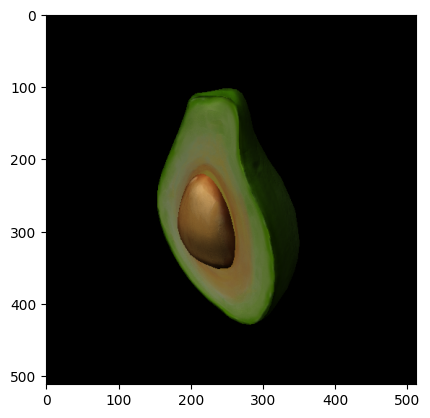

In [4]:
path = os.path.join(COMMON_DATA_DIR, 'meshes', 'gltf_avocado', 'Avocado.gltf')
mesh = kal.io.gltf.import_mesh(path)

mesh = mesh.cuda()
mesh.materials = [mat.cuda().hwc().contiguous() for mat in mesh.materials]

mesh.vertices = kal.ops.pointcloud.center_points(
    mesh.vertices.unsqueeze(0), normalize=True).squeeze(0)

azimuth = torch.zeros((1,), device='cuda')
elevation = torch.full((1,), math.pi / 3., device='cuda')
amplitude = torch.full((1, 3), 3., device='cuda')
sharpness = torch.full((1,), 5., device='cuda')

camera = kal.render.camera.Camera.from_args(
    eye=torch.ones((3,), dtype=torch.float, device='cuda'),
    at=torch.zeros((3,), dtype=torch.float, device='cuda'),
    up=torch.tensor([0., 1., 0.], dtype=torch.float),
    fov=math.pi * 45 / 180,
    height=512, width=512,
    near=0.1, far=10000.,
    device='cuda'
)

def render(camera):
    """Render using camera dimension.
    
    This is the main function provided to the interactive visualizer
    """
    output = base_render(camera, camera.height, camera.width, mesh,
                         azimuth, elevation, amplitude, sharpness)
    return output
    
def lowres_render(camera):
    """Render with lower dimension.
    
    This function will be used as a "fast" rendering used when the mouse is moving to avoid slow down.
    """
    output = base_render(camera, int(camera.height / 4), int(camera.width / 4), mesh,
                         azimuth, elevation, amplitude, sharpness)
    return output

output = render(camera)
plt.figure()
plt.imshow(output['img'].cpu().numpy())

# Interactive visualizer
We can now plug the camera and the renderer into the interactive visualizer, adding some ipywidgets interactive sliders to modify lighting

In [5]:
from ipywidgets import interactive, HBox, FloatSlider

visualizer = kal.visualize.IpyTurntableVisualizer(
    512, 512, copy.deepcopy(camera), render, fast_render=lowres_render, 
    max_fps=5, world_up_axis=1,
)

def sliders_callback(new_elevation, new_azimuth, new_amplitude, new_sharpness):
    """ipywidgets sliders callback"""
    with visualizer.out: # This is in case of bug
        elevation[:] = new_elevation
        azimuth[:] = new_azimuth
        amplitude[:] = new_amplitude
        sharpness[:] = new_sharpness
        # this is how we request a new update
        visualizer.render_update()
        
elevation_slider = FloatSlider(
    value=elevation.item(),
    min=-math.pi / 2.,
    max=math.pi / 2.,
    step=0.1,
    description='Elevation:',
    continuous_update=True,
    readout=True,
    readout_format='.1f',
)

azimuth_slider = FloatSlider(
    value=azimuth.item(),
    min=-math.pi,
    max=math.pi,
    step=0.1,
    description='Azimuth:',
    continuous_update=True,
    readout=True,
    readout_format='.1f',
)

amplitude_slider = FloatSlider(
    value=amplitude[0,0].item(),
    min=0.1,
    max=40.,
    step=0.1,
    description='Amplitude:\n',
    continuous_update=True,
    readout=True,
    readout_format='.1f',
)

sharpness_slider = FloatSlider(
    value=sharpness.item(),
    min=0.1,
    max=20.,
    step=0.1,
    description='Sharpness:\n',
    continuous_update=True,
    readout=True,
    readout_format='.1f',
)

interactive_slider = interactive(
    sliders_callback,
    new_elevation=elevation_slider,
    new_azimuth=azimuth_slider,
    new_amplitude=amplitude_slider,
    new_sharpness=sharpness_slider
)

# We combine all the widgets and the visualizer canvas and output in a single display
full_output = HBox([visualizer.canvas, interactive_slider])
display(full_output, visualizer.out)

Output()